# Projet SD-WAN-ReinforcementLearning

# Partie: Recherche opérationnelle

In [ ]:
#!pip install pulp

Imports

In [101]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

### Generation of random graph

In [46]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.fast_gnp_random_graph(nodes,edges/nodes,directed=True))
    return g

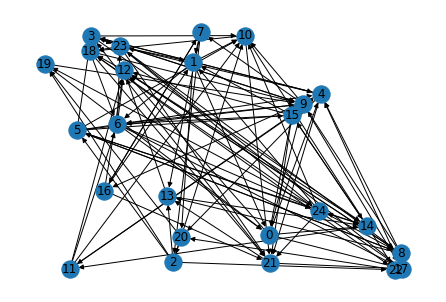

In [47]:
g = image_nertworkx()


node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
plt.savefig("images/original.jpg")
plt.show()

### Generation of random attributes for the graph edges

In [48]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [49]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(1.0, 20.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [50]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = min(round(random.uniform(0.0, 15.0), 0),dict_capa[i, j])
    
nx.set_edge_attributes(g, dict_used, 'used')

In [51]:
dict_ratio = {}
for i, j in g.edges:
    dict_ratio[i, j] = dict_ratio[j, i] = dict_used[i, j]/dict_capa[i, j]

nx.set_edge_attributes(g, dict_ratio, 'ratio')

In [52]:
dict_delay = {}
for i, j in g.edges:
    dict_delay[i, j] = dict_delay[j, i] = round(random.uniform(1.0, 20.0), 2)

nx.set_edge_attributes(g, dict_delay, 'delay')

Calculation of variable score based on previously generated attribute "ratio"

In [53]:
big_d = {}
small_d = {}

for link in g.edges:
    small_d = {}
    small_d['Source'] = link[0]
    small_d['Ratio'] = g.edges[link]['ratio']
 
    big_d[str(link)] = small_d
temp = pd.DataFrame.from_dict(big_d,orient='index')

temp = temp.sort_values(by=['Source','Ratio'])

for i in temp.Source.unique():
    cpt=0
    for j in temp[temp['Source'] == i].index:
        cpt+=1
        temp.at[str(j),'Score'] = cpt


Have to affect it twice to get attributes value on both directions

In [54]:
for link in g.edges:
    g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
        g.edges[link]['score'] = temp.at[str(link),'Score'] 

for link in  g.edges:
    if g.edges[link]['score'] != temp.at[str(link),'Score'] :
            g.edges[link]['score'] = temp.at[str(link),'Score'] 
            

### Instantiation 

In [103]:
# instantiate
list_keys = ['shortest_path','min_delay','min_banwidth_sum','min_banwidth_square_sum','min_score','min_square_score']
dict_prob = {}
dict_prob = dict_prob.fromkeys(list_keys)

opti_path = {}
opti_path = dict([(key, []) for key in list_keys])

target_dict = defaultdict(dict)

In [56]:
source = 5
target = 6

## RO Part



shortest_path
Optimal
3.0
Number of nodes= 3
Sum of delay = 35.64
Ratio Sum = 2.438888888888889
Squared Ratio Sum = 1.9926234567901235
Score Sum = 9.0
Squared Score Sum = 27.0
(5, 14) ,(11, 6) ,(14, 11) ,

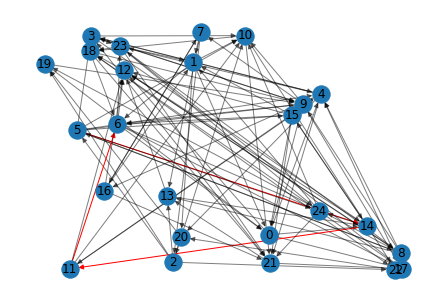


Press Enter to continue...


min_delay
Optimal
25.14
Number of nodes= 6
Sum of delay = 25.14
Ratio Sum = 2.9024455077086655
Squared Ratio Sum = 1.7828270816393037
Score Sum = 11.0
Squared Score Sum = 27.0
(0, 12) ,(5, 8) ,(8, 19) ,(12, 18) ,(18, 6) ,(19, 0) ,

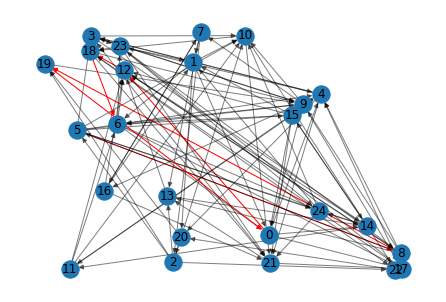


Press Enter to continue...


min_banwidth_sum
Optimal
2.2055944055944057
Number of nodes= 3
Sum of delay = 28.970000000000002
Ratio Sum = 2.2055944055944057
Squared Ratio Sum = 1.6366746540173116
Score Sum = 11.0
Squared Score Sum = 45.0
(5, 8) ,(8, 9) ,(9, 6) ,

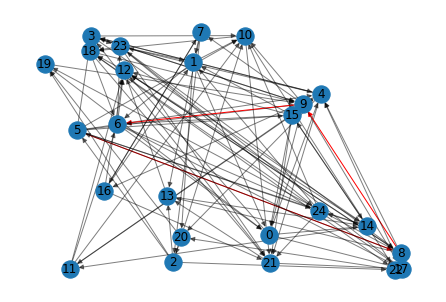


Press Enter to continue...


min_banwidth_square_sum
Optimal
1.1475096450617284
Number of nodes= 6
Sum of delay = 42.74
Ratio Sum = 2.2125
Squared Ratio Sum = 1.1475096450617284
Score Sum = 11.0
Squared Score Sum = 29.0
(2, 10) ,(4, 20) ,(5, 4) ,(10, 18) ,(18, 6) ,(20, 2) ,

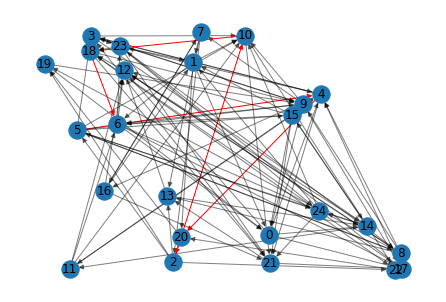


Press Enter to continue...


min_score
Optimal
9.0
Number of nodes= 4
Sum of delay = 39.11
Ratio Sum = 2.2189327485380117
Squared Ratio Sum = 1.5561552325929346
Score Sum = 9.0
Squared Score Sum = 27.0
(5, 14) ,(12, 18) ,(14, 12) ,(18, 6) ,

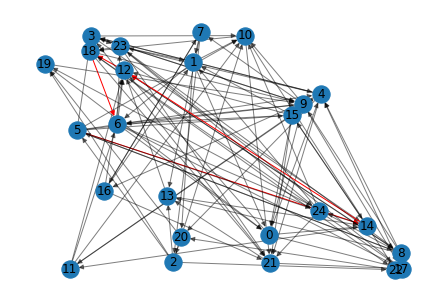


Press Enter to continue...


min_square_score
Optimal
25.0
Number of nodes= 7
Sum of delay = 40.7
Ratio Sum = 2.9144478844169246
Squared Ratio Sum = 1.6605562590518197
Score Sum = 11.0
Squared Score Sum = 25.0
(0, 12) ,(4, 20) ,(5, 4) ,(12, 18) ,(18, 6) ,(19, 0) ,(20, 19) ,

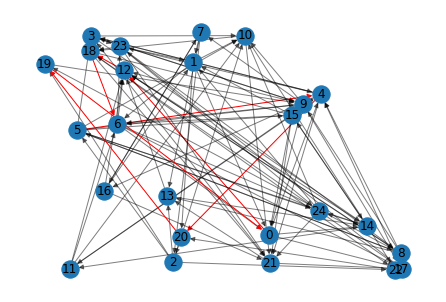


Press Enter to continue...


In [110]:
# binary variable to state a link is chosen or not

for keys,prob in dict_prob.items():
      prob = pulp.LpProblem("%s" % keys, pulp.LpMinimize)
      var_dict = {}
      for (i, j) in g.edges:
          x = pulp.LpVariable("%s_(%s_%s)" % (keys,i,j), cat=pulp.LpBinary)
          var_dict[i, j] = x
      bdw = 1

    # objective function
      if keys == "shortest_path":
        prob += pulp.lpSum(var_dict[i, j] for i, j in g.edges), "Sum Node Count"
      elif keys == "min_delay":
        prob += pulp.lpSum([g.edges[i, j]['delay'] * var_dict[i, j] for i, j in g.edges]), "Sum delay"
      elif keys == "min_banwidth_sum":
        prob += pulp.lpSum([g.edges[i, j]['ratio'] * var_dict[i, j] for i, j in g.edges]), "Sum bandwidth ratio"
      elif keys == "min_banwidth_square_sum":
        prob += pulp.lpSum([g.edges[i, j]['ratio'] ** 2 * var_dict[i, j] for i, j in g.edges]), "Sum square bandwidth ratio"
      elif keys == "min_score":
        prob += pulp.lpSum([g.edges[i, j]['score'] * var_dict[i, j] for i, j in g.edges]), "Sum score"
      elif keys == "min_square_score":
        prob += pulp.lpSum([(g.edges[i, j]['score'] ** 2 * var_dict[i, j]) for i, j in g.edges]), "Sum square score"

    # constraints
      for node in g.nodes:
          rhs = 0
          if node == source:
              rhs = -1
          elif node == target:
              rhs = 1
          prob += pulp.lpSum([var_dict[i, k] for i, k in g.edges if k == node]) - pulp.lpSum([var_dict[k, j] for k, j in g.edges if k == node]) == rhs

     # constraints on capacity
      for i,k in g.edges:
         prob += var_dict[i, k]*bdw + g.edges[i,k]['used']  <= g.edges[i,k]['capacity']

      # solve
      prob.solve()
      print("\n\n" + str(keys))
      print(pulp.LpStatus[prob.status])
      print(pulp.value(prob.objective))
    
      solve_var = []
      for i in prob.variables():
          if i.varValue == 1:
              var = str(i).split('(')
              var = var[1].split('_')
              var[0] = int(var[0])
              var[1] = int(var[1].strip(')'))
              solve_var.append(tuple(var))
      print("Number of nodes= {}".format(len(solve_var)))
      print("Sum of delay = {}".format(sum([g.edges[i, j]['delay'] for i, j in solve_var])))
      print("Ratio Sum = {}".format(sum([g.edges[i, j]['ratio'] for i, j in solve_var])))
      print("Squared Ratio Sum = {}".format(sum([g.edges[i, j]['ratio']**2 for i, j in solve_var])))
      print("Score Sum = {}".format(sum([g.edges[i, j]['score'] for i, j in solve_var])))
      print("Squared Score Sum = {}".format(sum([g.edges[i, j]['score']**2 for i, j in solve_var])))
      
      target_dict[keys]['Number of nodes'] = len(solve_var)
      target_dict[keys]['Sum of delay'] = sum([g.edges[i, j]['delay'] for i, j in solve_var])
      target_dict[keys]['Ratio Sum'] = sum([g.edges[i, j]['ratio'] for i, j in solve_var])
      target_dict[keys]['Squared Ratio Sum'] = sum([g.edges[i, j]['ratio']**2 for i, j in solve_var])
      target_dict[keys]['Score Sum'] = sum([g.edges[i, j]['score'] for i, j in solve_var])
      target_dict[keys]['Squared Score Sum'] = sum([g.edges[i, j]['score']**2 for i, j in solve_var])
        
      for link in g.edges:
          if var_dict[link].value() == 1.0:
              print(link, end=" ,")
              opti_path[keys].append(link)
              g.edges[link[0],link[1]]['color'] = (1,0,0,1) 

      colors = nx.get_edge_attributes(g,'color').values()

      nx.draw(g, pos = node_pose, 
            edge_color=colors, 
            with_labels=True)

      plt.savefig("images/{}.jpg".format(keys))
      plt.show()

      color = {}
      for i, j in g.edges:
          color[i, j] = color[j, i] = (0,0,0,0.5)

      nx.set_edge_attributes(g, color, 'color')

      print("")

      input("Press Enter to continue...")
      

In [111]:
df = pd.DataFrame.from_dict(target_dict)
df

,shortest_path,min_delay,min_banwidth_sum,min_banwidth_square_sum,min_score,min_square_score
Number of nodes,3.000000,6.000000,3.000000,6.00000,4.000000,7.000000
Sum of delay,35.640000,25.140000,28.970000,42.74000,39.110000,40.700000
Ratio Sum,2.438889,2.902446,2.205594,2.21250,2.218933,2.914448
Squared Ratio Sum,1.992623,1.782827,1.636675,1.14751,1.556155,1.660556
Score Sum,9.000000,11.000000,11.000000,11.00000,9.000000,11.000000
Squared Score Sum,27.000000,27.000000,45.000000,29.00000,27.000000,25.000000
